<a href="https://colab.research.google.com/github/codesanya/dobbe-xray-preprocessing/blob/main/notebooks/code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
import os
import pydicom
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import pywt
import seaborn as sns

data_path = '/content/drive/MyDrive/Images_Data_science_intern'
print(os.listdir(data_path))


['IS20250116_180218_7445_56958340.dcm', 'R9.rvg', 'R5.rvg', 'IS20250115_190348_9148_86297118.dcm', 'R6.rvg', 'R10.rvg', 'R7.rvg', 'IS20250115_171841_9465_61003253.dcm', 'IS20250218_193552_3393_78829426.dcm', 'R4.rvg', 'IS20250115_191316_7227_10120577.dcm', 'IS20250221_192657_5718_56712676.dcm', 'Reference_Output_Quality.jpg', 'IS20250218_193621_8940_10081171.dcm']


In [39]:
!git clone https://github.com/codesanya/dobbe-xray-preprocessing.git
%cd dobbe-xray-preprocessing

Cloning into 'dobbe-xray-preprocessing'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 32 (delta 4), reused 13 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (32/32), 2.45 MiB | 17.16 MiB/s, done.
Resolving deltas: 100% (4/4), done.
/content/dobbe-xray-preprocessing/dobbe-xray-preprocessing


In [40]:
!pip install pydicom opencv-python-headless scikit-image matplotlib

In [41]:
all_files = os.listdir(data_path)
dcm_files = [f for f in all_files if f.endswith('.dcm')]
print("DICOM files:", dcm_files)

DICOM files: ['IS20250116_180218_7445_56958340.dcm', 'IS20250115_190348_9148_86297118.dcm', 'IS20250115_171841_9465_61003253.dcm', 'IS20250218_193552_3393_78829426.dcm', 'IS20250115_191316_7227_10120577.dcm', 'IS20250221_192657_5718_56712676.dcm', 'IS20250218_193621_8940_10081171.dcm']


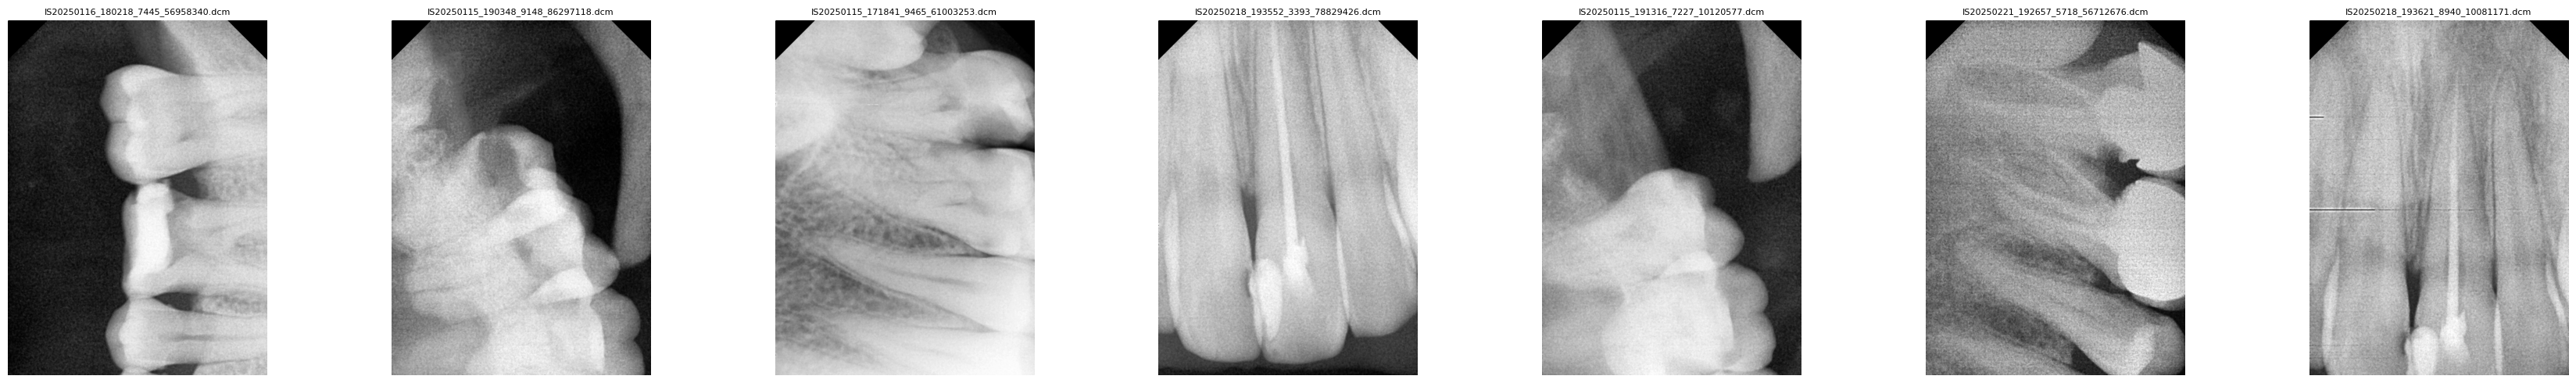

In [42]:
fig, axes = plt.subplots(1, len(dcm_files), figsize=(5 * len(dcm_files), 5))
if len(dcm_files) == 1:
    axes = [axes]

for ax, file in zip(axes, dcm_files):
    file_path = os.path.join(data_path, file)
    dicom_data = pydicom.dcmread(file_path)
    ax.imshow(dicom_data.pixel_array, cmap="gray")
    ax.set_title(file, fontsize=8)
    ax.axis("off")

plt.tight_layout()
plt.show()

In [43]:
def load_dicom(file_path):
    dicom = pydicom.dcmread(file_path)
    image = dicom.pixel_array
    metadata = {
        "PatientID": dicom.get("PatientID", "Unknown"),
        "Modality": dicom.get("Modality", "Unknown"),
        "StudyDate": dicom.get("StudyDate", "Unknown"),
        "PixelSpacing": dicom.get("PixelSpacing", "Unknown"),
        "PhotometricInterpretation": dicom.get("PhotometricInterpretation", "Unknown"),
        "SOPClassUID": dicom.get("SOPClassUID", "Unknown")
    }
    return image, metadata

folder_path = data_path
dcm_files = [f for f in os.listdir(folder_path) if f.endswith('.dcm')]
print(f"Found {len(dcm_files)} DICOM files.")

Found 7 DICOM files.


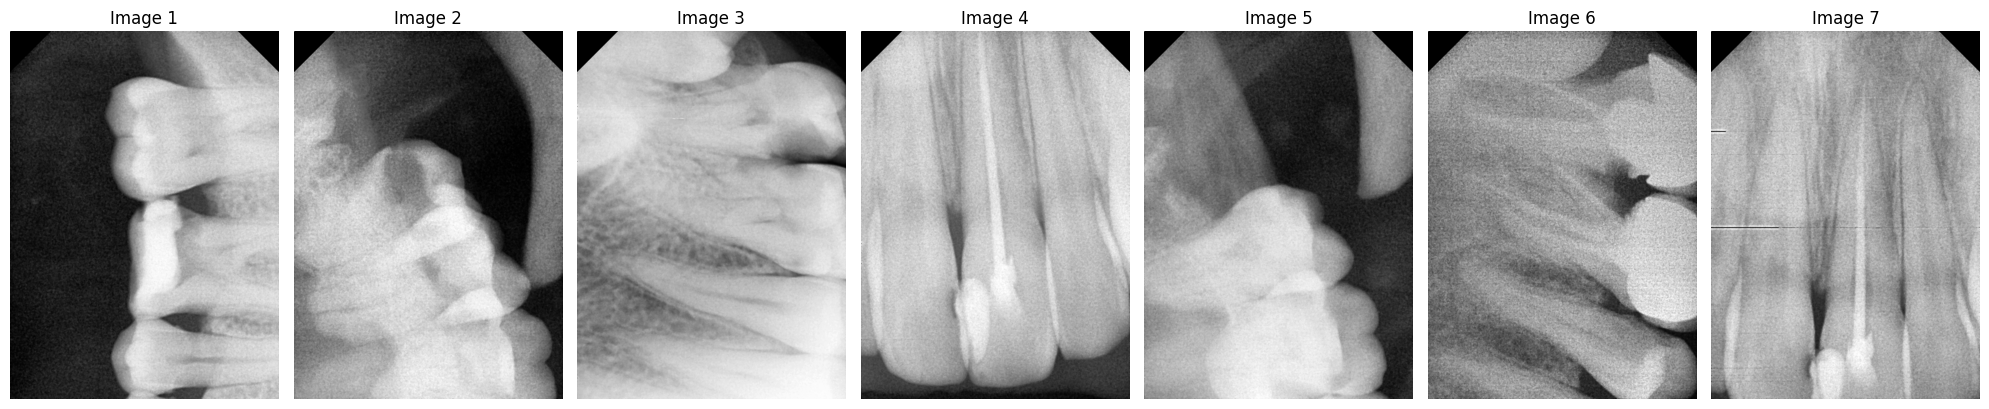

In [44]:
plt.figure(figsize=(20, 5))

for i, filename in enumerate(dcm_files):
    filepath = os.path.join(folder_path, filename)
    image, metadata = load_dicom(filepath)
    plt.subplot(1, len(dcm_files), i + 1)
    plt.imshow(image, cmap='gray')
    plt.title(f"Image {i+1}")
    plt.axis('off')

plt.tight_layout()
plt.show()

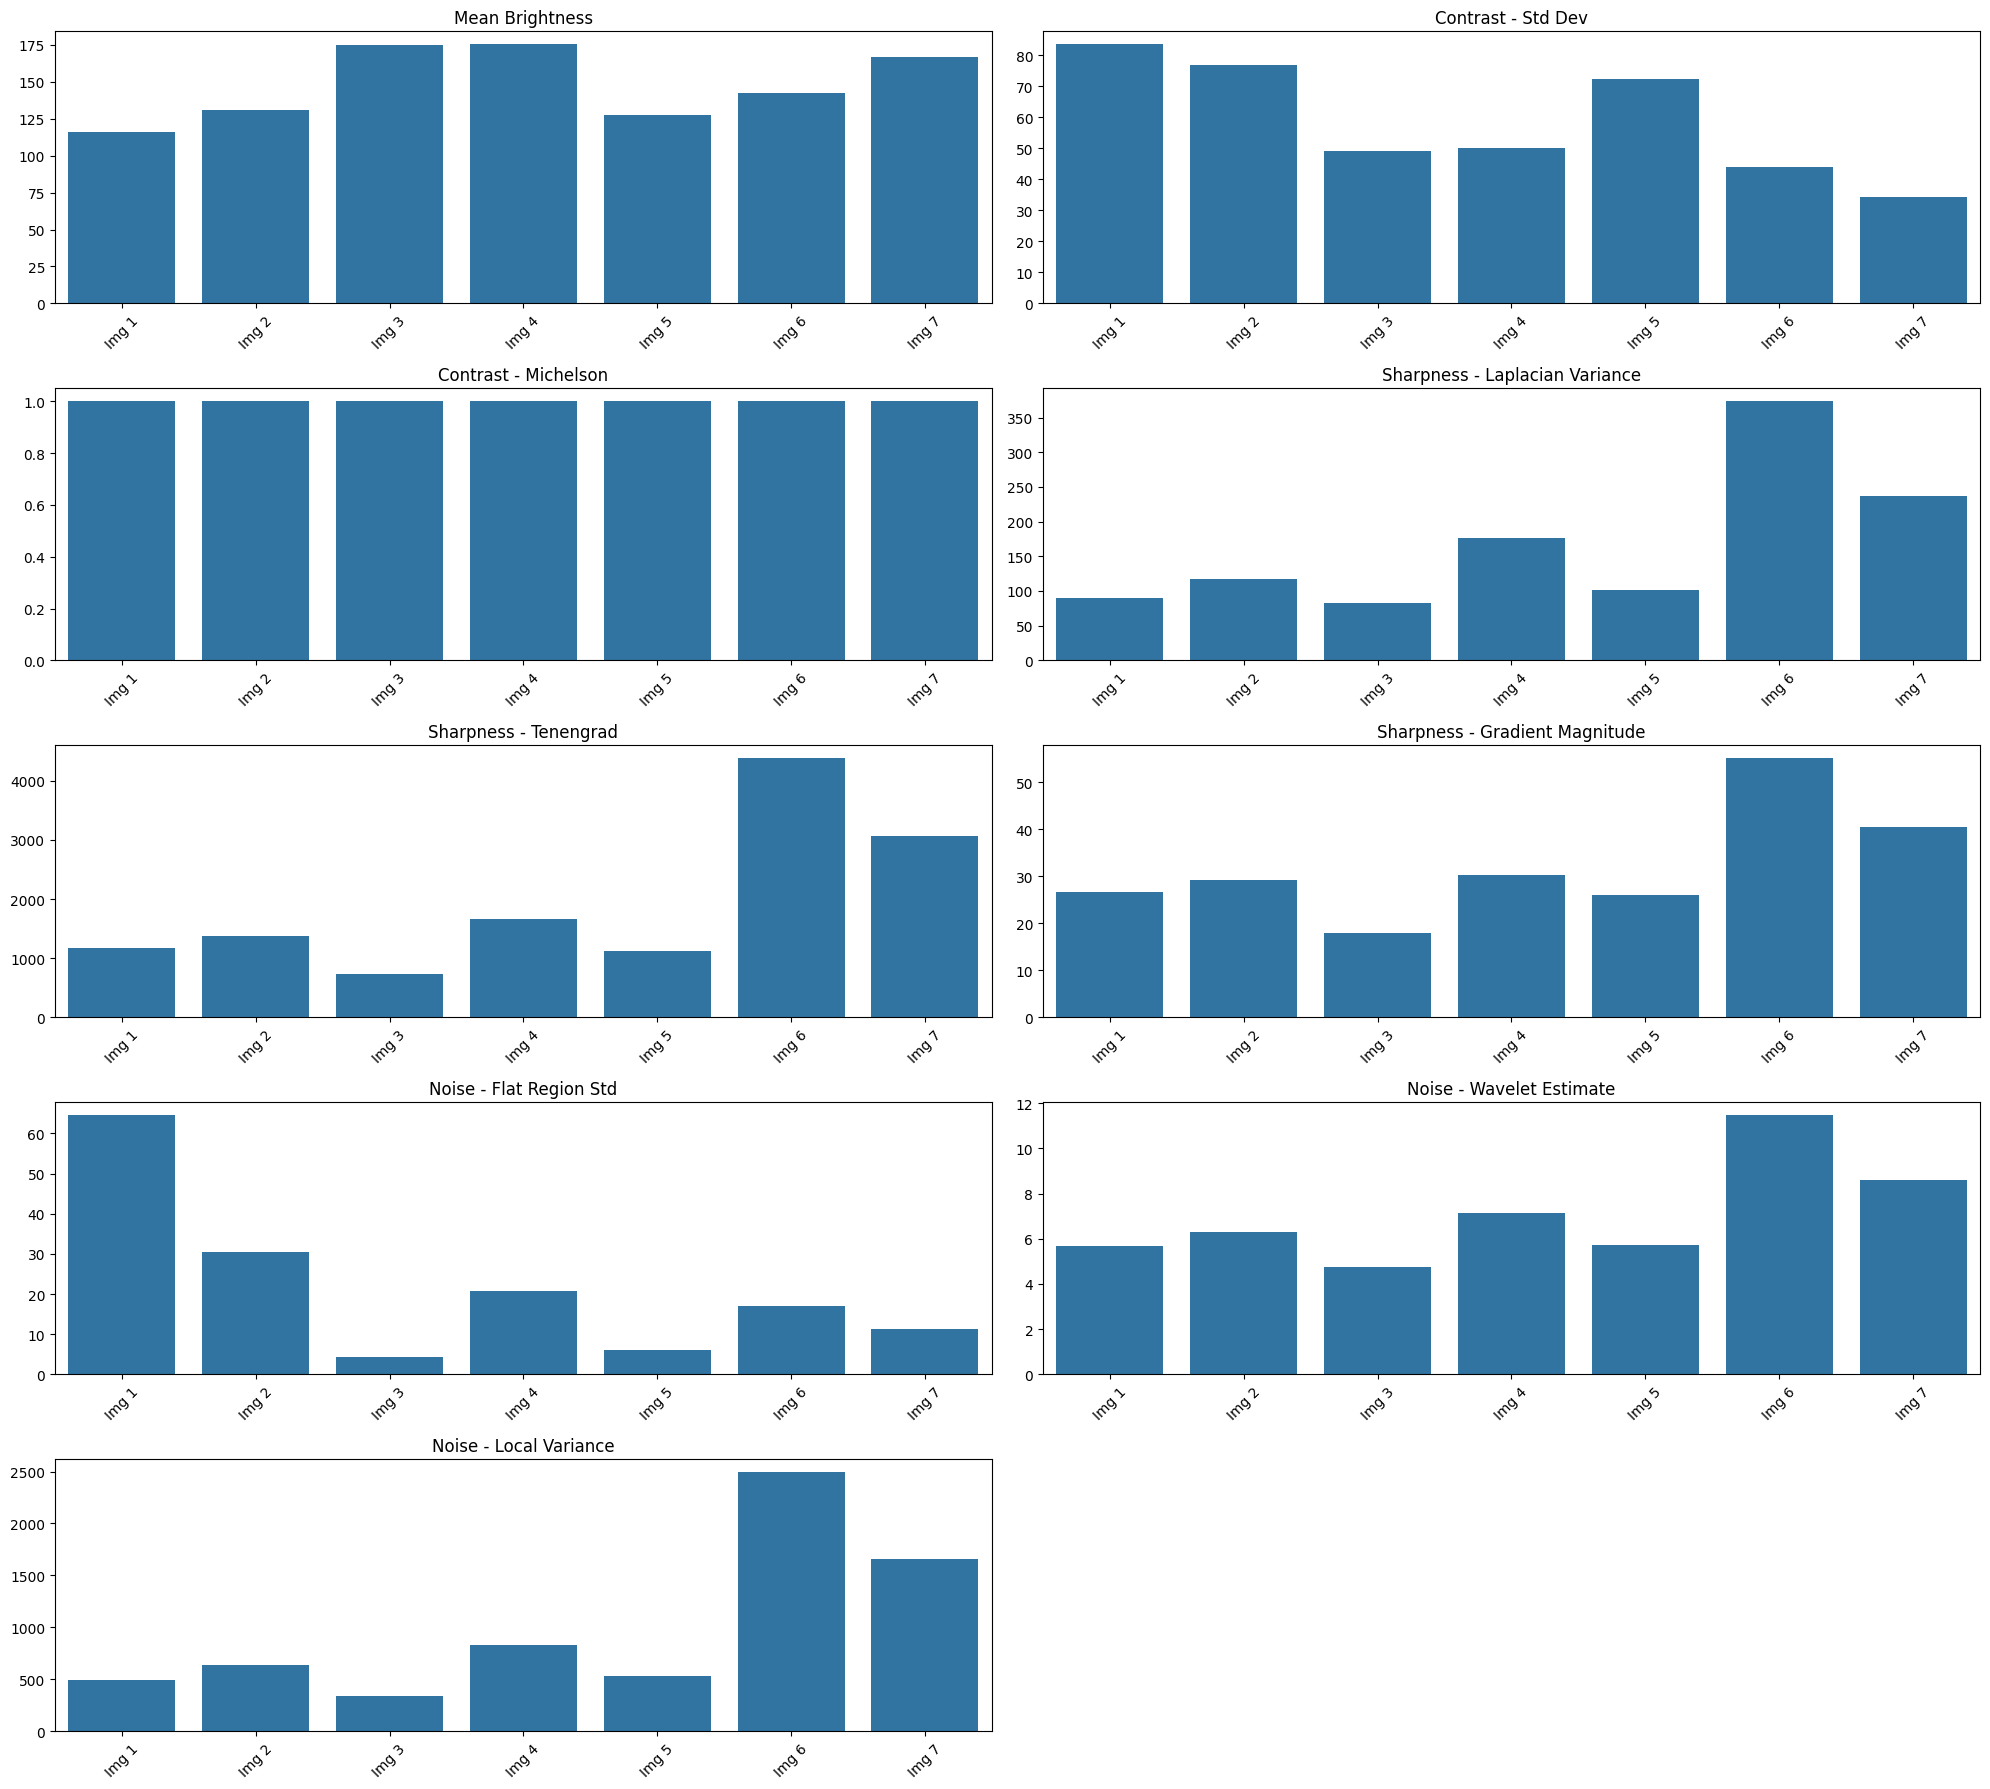

In [45]:
# Store metrics for all methods
results = {
    "Brightness_Mean": [],
    "Contrast_Std": [],
    "Contrast_Michelson": [],
    "Sharp_Laplacian": [],
    "Sharp_Tenengrad": [],
    "Sharp_GradientMag": [],
    "Noise_FlatStd": [],
    "Noise_Wavelet": [],
    "Noise_LocalVar": []
}


def plot_histograms(metric_name, values_list, xlabel, bins=50):
    plt.figure(figsize=(12, 6))
    for i, values in enumerate(values_list):
        plt.hist(values.flatten(), bins=bins, alpha=0.6, label=f"Image {i+1}")
    plt.title(f"{metric_name} Histogram")
    plt.xlabel(xlabel)
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True)
    plt.show()

def compute_brightness(img):
    return np.mean(img)

def compute_contrast_std(img):
    return np.std(img)


def compute_contrast_michelson(img):
    img = img.astype(np.float32)
    I_max = np.max(img)
    I_min = np.min(img)
    if I_max + I_min == 0:
        return 0
    return (I_max - I_min) / (I_max + I_min)

def compute_sharpness_laplacian(img):
    return cv2.Laplacian(img, cv2.CV_64F).var()

def compute_sharpness_tenengrad(img):
    gx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
    gy = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
    return np.mean(gx ** 2 + gy ** 2)

def estimate_noise_std(img):
    coeffs = pywt.wavedec2(img, 'db1', level=1)
    _, (cH, cV, cD) = coeffs
    return np.median(np.abs(cD)) / 0.6745


for filename in dcm_files:
    filepath = os.path.join(folder_path, filename)
    image, metadata = load_dicom(filepath)
    norm_img = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    # Brightness
    results["Brightness_Mean"].append(compute_brightness(norm_img))

    # Contrast
    results["Contrast_Std"].append(compute_contrast_std(norm_img))
    results["Contrast_Michelson"].append(compute_contrast_michelson(norm_img))

    # Sharpness
    results["Sharp_Laplacian"].append(compute_sharpness_laplacian(norm_img))
    results["Sharp_Tenengrad"].append(compute_sharpness_tenengrad(norm_img))
    gradient_mag = np.mean(cv2.magnitude(cv2.Sobel(norm_img, cv2.CV_64F, 1, 0), cv2.Sobel(norm_img, cv2.CV_64F, 0, 1)))
    results["Sharp_GradientMag"].append(gradient_mag)

    # Noise (Flat region: center crop 50x50)
    h, w = norm_img.shape
    crop = norm_img[h//2 - 25:h//2 + 25, w//2 - 25:w//2 + 25]
    results["Noise_FlatStd"].append(np.std(crop))

    # Wavelet noise estimate
    coeffs = pywt.dwt2(norm_img, 'db1')
    _, (cH, cV, cD) = coeffs
    wavelet_noise = np.sqrt(np.mean(cH**2 + cV**2 + cD**2))
    results["Noise_Wavelet"].append(wavelet_noise)

    # Local variance (kernel sliding window)
    local_var = cv2.Laplacian(norm_img, cv2.CV_64F, ksize=3).var()
    results["Noise_LocalVar"].append(local_var)


metric_titles = {
    "Brightness_Mean": "Mean Brightness",
    "Contrast_Std": "Contrast - Std Dev",
    "Contrast_Michelson": "Contrast - Michelson",
    "Sharp_Laplacian": "Sharpness - Laplacian Variance",
    "Sharp_Tenengrad": "Sharpness - Tenengrad",
    "Sharp_GradientMag": "Sharpness - Gradient Magnitude",
    "Noise_FlatStd": "Noise - Flat Region Std",
    "Noise_Wavelet": "Noise - Wavelet Estimate",
    "Noise_LocalVar": "Noise - Local Variance"
}

plt.figure(figsize=(20, 18))
for i, (key, values) in enumerate(results.items()):
    plt.subplot(5, 2, i + 1)
    sns.barplot(x=[f"Img {i+1}" for i in range(len(values))], y=values)
    plt.title(metric_titles[key])
    plt.xticks(rotation=45)
    plt.tight_layout()
plt.show()


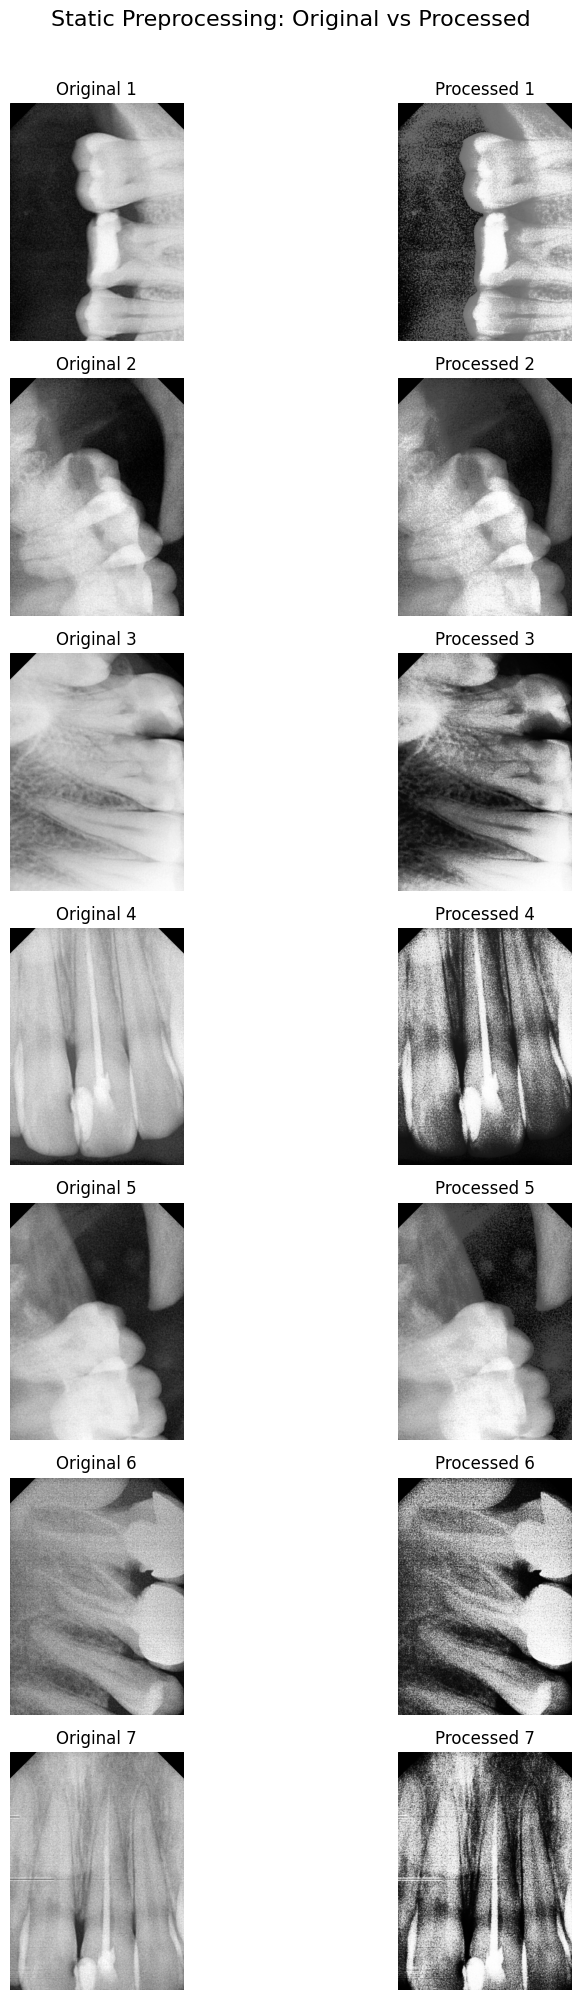

In [46]:
dicom_data = [pydicom.dcmread(os.path.join(folder_path, f)) for f in dcm_files]

def histogram_equalization(img):
    img_uint8 = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    return cv2.equalizeHist(img_uint8)

def sharpen_image(img):
    kernel = np.array([[0, -1, 0],
                       [-1, 5,-1],
                       [0, -1, 0]])
    return cv2.filter2D(img, -1, kernel)

def denoise_image(img):
    return cv2.GaussianBlur(img, (5, 5), 0)

# Static preprocessing pipeline
def static_preprocess(img):
    img = histogram_equalization(img)
    img = sharpen_image(img)
    img = denoise_image(img)
    return img

fig, axes = plt.subplots(len(dcm_files), 2, figsize=(10, 3*len(dcm_files)))
fig.suptitle("Static Preprocessing: Original vs Processed", fontsize=16)

for i, ds in enumerate(dicom_data):
    img = ds.pixel_array.astype(np.float32)
    processed_img = static_preprocess(img)

    axes[i, 0].imshow(img, cmap='gray')
    axes[i, 0].set_title(f"Original {i+1}")
    axes[i, 0].axis('off')

    axes[i, 1].imshow(processed_img, cmap='gray')
    axes[i, 1].set_title(f"Processed {i+1}")
    axes[i, 1].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()


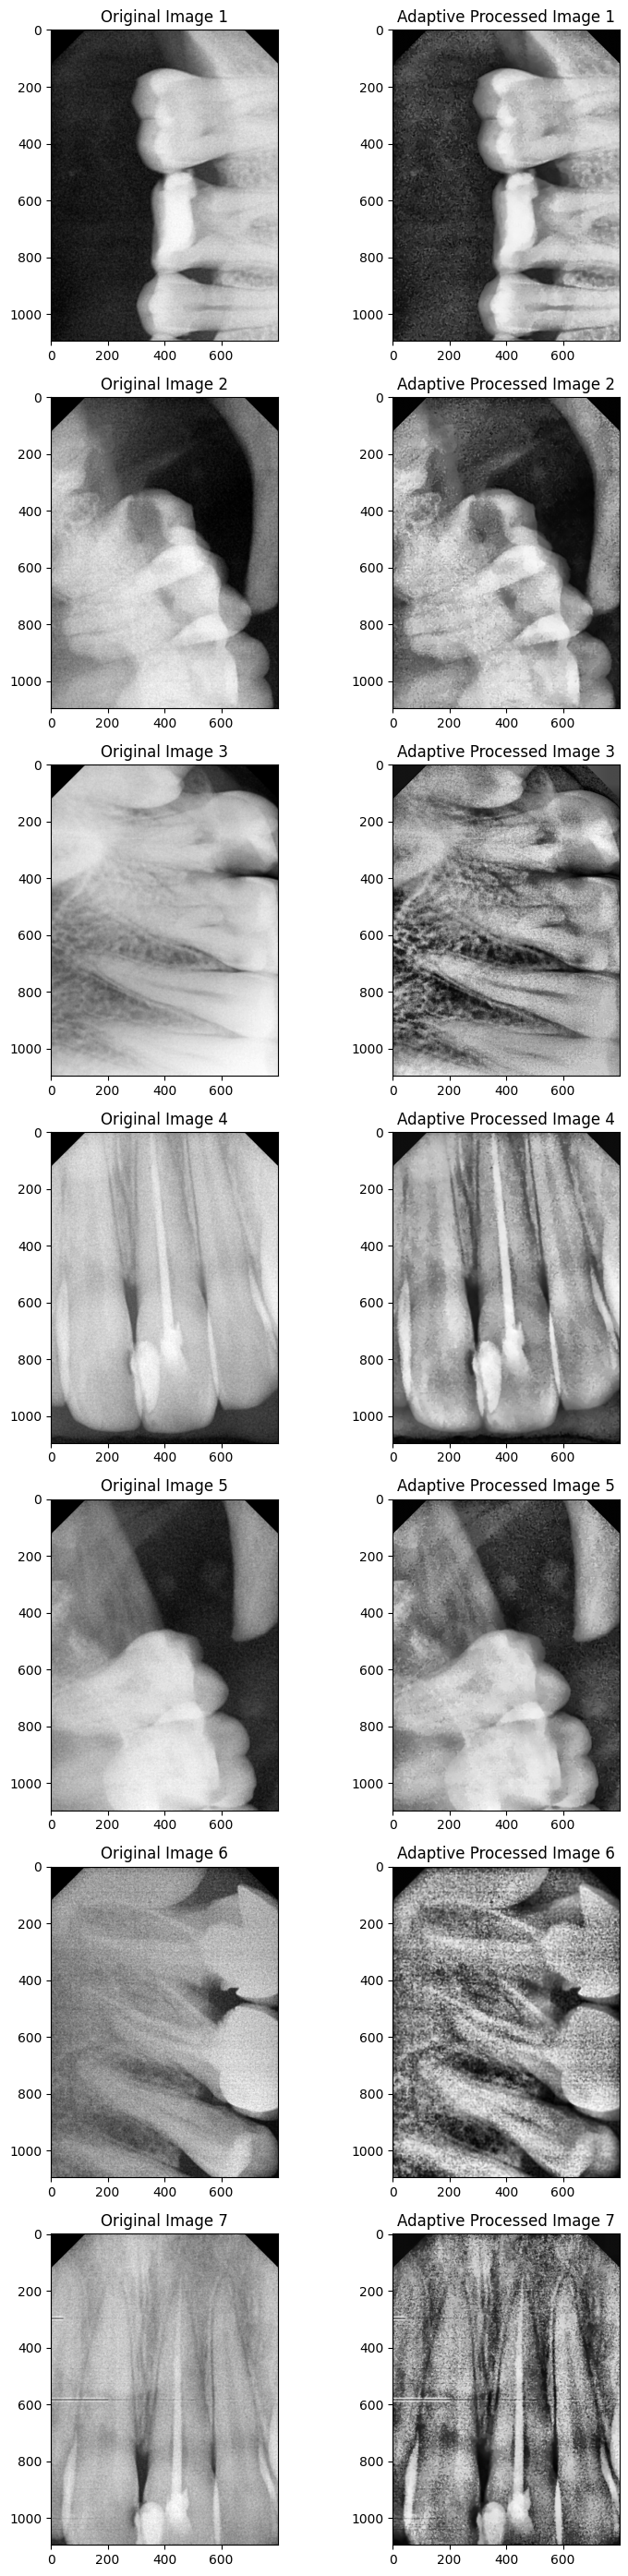

In [47]:
def adaptive_preprocess(img):
    img = img.astype(np.uint8)

    # Compute metrics
    brightness = compute_brightness(img)
    contrast = compute_contrast_std(img)
    sharpness = compute_sharpness_laplacian(img)
    noise = estimate_noise_std(img)

    # Brightness
    if brightness < 100:
        img = cv2.convertScaleAbs(img, alpha=1.2, beta=20)  # brighten
    elif brightness > 150:
        img = cv2.convertScaleAbs(img, alpha=0.8, beta=-20)  # darken

    # Contrast Enhancement
    if contrast > 70:
        clahe_clip = 1.5
    elif contrast > 50:
        clahe_clip = 2.5
    elif contrast > 30:
        clahe_clip = 4.5
    else:
        clahe_clip = 4.0
    clahe = cv2.createCLAHE(clipLimit=clahe_clip, tileGridSize=(8, 8))
    img = clahe.apply(img)

    # Sharpness Enhancement (unsharp masking)
    if sharpness < 150:
        blurred = cv2.GaussianBlur(img, (9, 9), 3.0)
        img = cv2.addWeighted(img, 1.5, blurred, -0.5, 0)


    # Noise Reduction
    if noise > 2:
        img = cv2.bilateralFilter(img, d=9, sigmaColor=75, sigmaSpace=75)
    elif noise > 1.2:
        img = cv2.fastNlMeansDenoising(img, h=12)

    img = cv2.normalize(img, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

    return img


def show_adaptive(dicom_data):
    fig, axs = plt.subplots(len(dicom_data), 2, figsize=(8, 4 * len(dicom_data)))

    for i, ds in enumerate(dicom_data):
        try:
            original = ds.pixel_array.astype(np.uint8)
            processed = adaptive_preprocess(original)

            axs[i, 0].imshow(original, cmap='gray')
            axs[i, 0].set_title(f"Original Image {i+1}")
            axs[i, 1].imshow(processed, cmap='gray')
            axs[i, 1].set_title(f"Adaptive Processed Image {i+1}")
        except Exception as e:
            print(f"Error processing image {i+1}: {e}")

    plt.tight_layout()
    plt.show()


show_adaptive(dicom_data)

In [48]:
def compute_all_metrics(img):
    brightness = compute_brightness(img)
    contrast_std = compute_contrast_std(img)
    #contrast_rms = compute_contrast_rms(img)
    contrast_mich = compute_contrast_michelson(img)
    sharpness_lap = compute_sharpness_laplacian(img)
    sharpness_ten = compute_sharpness_tenengrad(img)
    noise = estimate_noise_std(img)
    return {
        "Brightness": brightness,
        "Contrast_STD": contrast_std,
        "Contrast_Mich": contrast_mich,
        "Sharpness_Lap": sharpness_lap,
        "Sharpness_Ten": sharpness_ten,
        "Noise_Est": noise
    }

before_metrics = []
after_metrics = []

for i, ds in enumerate(dicom_data):
    try:
        original = ds.pixel_array.astype(np.uint8)
        processed = adaptive_preprocess(original)

        before = compute_all_metrics(original)
        after = compute_all_metrics(processed)

        before_metrics.append(before)
        after_metrics.append(after)

    except Exception as e:
        print(f"Error processing image {i+1}: {e}")

df_before = pd.DataFrame(before_metrics)
df_after = pd.DataFrame(after_metrics)

df_comparison = pd.concat([df_before.add_suffix("_Before"), df_after.add_suffix("_After")], axis=1)
df_comparison.index = [f"Image {i+1}" for i in range(len(before_metrics))]

# ---------- Display ----------
pd.set_option('display.max_columns', None)
print(df_comparison.round(2))


         Brightness_Before  Contrast_STD_Before  Contrast_Mich_Before  \
Image 1             116.35                83.57                   1.0   
Image 2             130.84                76.73                   1.0   
Image 3             174.68                49.16                   1.0   
Image 4             175.43                50.17                   1.0   
Image 5             127.78                72.30                   1.0   
Image 6             142.20                43.95                   1.0   
Image 7             166.90                34.43                   1.0   

         Sharpness_Lap_Before  Sharpness_Ten_Before  Noise_Est_Before  \
Image 1                 89.44               1171.73              1.48   
Image 2                116.70               1383.18              1.48   
Image 3                 82.74                730.63              0.74   
Image 4                175.70               1658.82              1.48   
Image 5                101.51               1124.7